In [1]:
import xarray as xr
import numpy as np
import glob

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *

utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-02-02 10:19:35.683613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 10:19:35.702431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738516775.720328   71264 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738516775.726136   71264 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 10:19:35.746681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/tmp/'
#dir = '/glade/work/linnia/CLM5-PPE/post_processed_modis_biomes/tmp/'

In [5]:
f=sorted(glob.glob(dir+'BNF_v2.n01_ctsm5.3.012_transient*.postp.nc')) 
ds = xr.open_mfdataset(f,combine='nested',concat_dim='ens')

#f=sorted(glob.glob(dir+'PPEn11_transient_LHC*.postp.nc')) 
#ds = xr.open_mfdataset(f,combine='nested',concat_dim='ens')

In [6]:
### set crashers to nan and add coord
ens_indices = [40,85,236,1166,1286,1323,1389]

for var in ds.data_vars:
    ds[var].loc[{'ens': ens_indices}] = np.nan

crashed = np.zeros(len(ds.ens))
crashed[ens_indices] = 1
ds = ds.assign_coords(crashed=('ens', crashed))

In [7]:
### Add parameters as variables
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
df_key = pd.read_csv(key)

for col in df_key.columns:
    ds[col] = ('ens', np.concatenate(([np.nan],df_key[col].values)))  # Add the parameter as a variable with 'ens' dimension


In [8]:
### Add metadata
ds.attrs= {'created_by': 'linnia lh3194@columbia.edu', 
           'created_on': '01/29/2025',
           'created_with': '/glade/u/home/linnia/ctsm6_ppe/postprocessing/postp_lhc_pftmean.py and concat_ens.ipynb',
           'github_repo': 'https://github.com/NCAR/ctsm6_ppe'}

In [9]:
ds_ens = ds.compute()

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 17.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [10]:
ds_ens.to_netcdf('/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pftmean_amax_1985-2023.nc')
#ds_ens.to_netcdf('/glade/work/linnia/CLM5-PPE/post_processed_modis_biomes/postp/clm5ppe_lhc_MODISbmean_1850-2023.nc')

### Check

In [11]:
ds = xr.open_dataset(dir+'ctsm6lhc_amean_gmean_bmean_1850-2023.nc')

In [15]:
gpp = ds.GPP_biome_amean.sel(year=slice(1986,2015)).mean(dim='year').compute()

In [16]:
lai = ds.TLAI_biome_amean.sel(year=slice(1986,2015)).mean(dim='year').compute()

Text(0, 0.5, 'GPP (PgC/yr)')

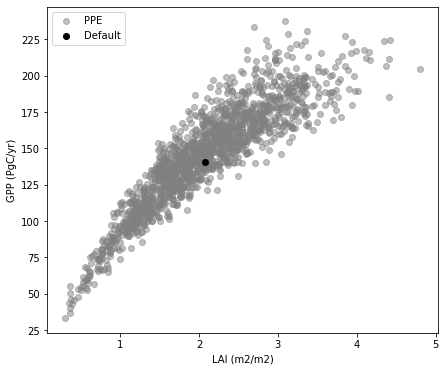

In [14]:
plt.figure(figsize=(7,6))
la=xr.open_dataset(utils_path+'landarea_retrain_h0.nc').landarea
plt.scatter(lai,60*60*24*365*1E-9*la.sum()*gpp,c='grey',alpha = 0.5,label='PPE')
plt.scatter(lai[0],60*60*24*365*1E-9*la.sum()*gpp[0],c='k',label='Default')
plt.legend()
plt.xlabel('LAI (m2/m2)')
plt.ylabel('GPP (PgC/yr)')

In [24]:
whit = xr.open_dataset(utils_path+'whit/whitkey_CRUJRA.nc')
whit.biome_name[1].values

array('Tropical rain forest', dtype='<U20')

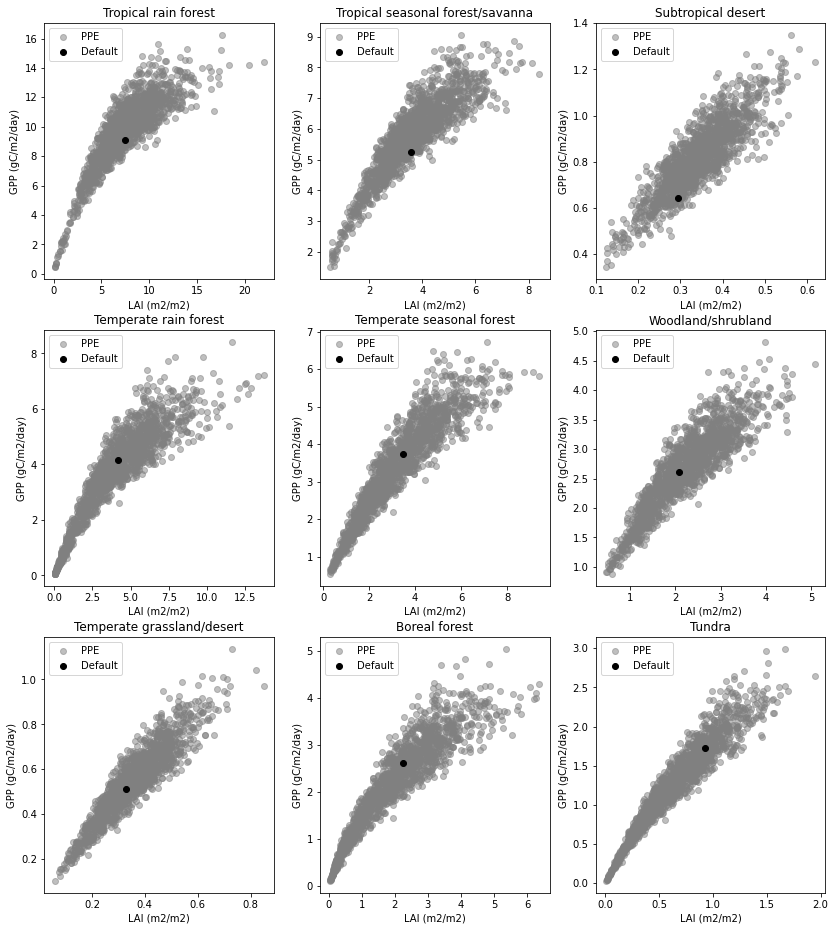

In [28]:
plt.figure(figsize=(14,16))
la=xr.open_dataset(utils_path+'landarea_retrain_h0.nc').landarea

for b in range(1,10):
    plt.subplot(3,3,b)
    plt.scatter(lai.sel(biome=b),60*60*24*gpp.sel(biome=b),c='grey',alpha = 0.5,label='PPE')
    plt.scatter(lai[0].sel(biome=b),60*60*24*gpp[0].sel(biome=b),c='k',label='Default')
    plt.legend()
    plt.xlabel('LAI (m2/m2)')
    plt.ylabel('GPP (gC/m2/day)')
    plt.title(whit.biome_name[b].values)

In [15]:
ds = xr.open_dataset(dir+'ctsm6lhc_amean_pSASU.nc')

In [12]:
ds.TLAI_biome_amean.isel(biome=3).mean(dim='year').values

array([5.86537197, 6.55610753])